# Dataflow using NVIDIA/DALI

In [5]:
# !pip3 install --extra-index-url https://developer.download.nvidia.com/compute/redist nvidia-dali

In [1]:
import sys

sys.path.insert(0, "../code/deeplab")

In [2]:
from image_dataset_viz import render_datapoint

In [3]:
try:
    from nvidia.dali.plugin.pytorch import DALIClassificationIterator
    from nvidia.dali.pipeline import Pipeline
    import nvidia.dali.ops as ops
    import nvidia.dali.types as types
except ImportError:
    raise ImportError("Please install DALI from https://www.github.com/NVIDIA/DALI to run this example.")

In [4]:
import numpy as np
from torchvision.datasets.voc import VOCSegmentation


class VOCSegmentationDALIInputIterator(VOCSegmentation):
    
    def __init__(self, batch_size, **dataset_kwargs):
        self.batch_size = batch_size
        super(VOCSegmentationDALIInputIterator, self).__init__(**dataset_kwargs)
        
    def __iter__(self):
        self.i = 0
        self.n = len(self)        
        return self
    
    def __getitem__(self, index):
        image_filepath = self.images[index]
        mask_filepath = self.masks[index]
        
        image_file = open(image_filepath, 'rb')
        mask_file = open(mask_filepath, 'rb')
        
        encoded_image = np.frombuffer(image_file.read(), dtype = np.uint8)
        encoded_mask = np.frombuffer(mask_file.read(), dtype = np.uint8)
        
        return encoded_image, encoded_mask
        
    def __next__(self):
        batch_encoded_images = []
        batch_encoded_masks = []
        
        for _ in range(self.batch_size):
            encoded_image, encoded_mask = self[self.i]
            batch_encoded_images.append(encoded_image)
            batch_encoded_masks.append(encoded_mask)
            self.i = (self.i + 1) % self.n

        return batch_encoded_images, batch_encoded_masks

    next = __next__

In [5]:
class VOCSegmentationSourcePipeline(Pipeline):
    
    def __init__(self, batch_size, num_threads, device_id, seed=12, **dataset_kwargs):
        super(VOCSegmentationSourcePipeline, self).__init__(batch_size, 
                                                            num_threads,
                                                            device_id,
                                                            seed=seed)
        self._iterator = iter(VOCSegmentationDALIInputIterator(batch_size, **dataset_kwargs))
        self.input_images = ops.ExternalSource()
        self.input_masks = ops.ExternalSource()
        self.image_decode = ops.nvJPEGDecoder(device="mixed", output_type=types.RGB)
        self.mask_decode = ops.HostDecoder(output_type=types.RGB)        
        
    def define_graph(self):
        self.images = self.input_images(name="ImageReader")
        self.masks = self.input_masks(name="MaskReader")
        images = self.image_decode(self.images)
        masks = self.mask_decode(self.masks).gpu()
        return (images, masks)

    def iter_setup(self):
        images, labels = self._iterator.next()
        self.feed_input(self.images, images)
        self.feed_input(self.masks, labels)
        

In [6]:
pipe = VOCSegmentationSourcePipeline(root="/home/storage_ext4_1tb/", batch_size=4, num_threads=2, device_id=0)
pipe.build()
pipe_out = pipe.run()

In [7]:
x, y = pipe_out

In [8]:
img1 = x.asCPU().at(1)
mask1 = y.asCPU().at(1).astype(np.uint8)

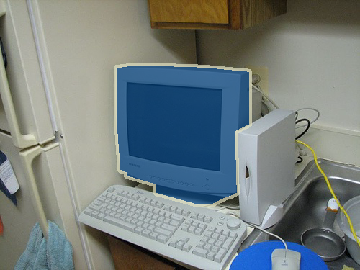

In [9]:
render_datapoint(img1, mask1, output_size=(360, 360))

### With Data augmentations

In [15]:
class VOCSegmentationAugmentedPipeline(VOCSegmentationSourcePipeline):
    
    def __init__(self, batch_size, num_threads, device_id, seed=12, **dataset_kwargs):
        super(VOCSegmentationAugmentedPipeline, self).__init__(batch_size, 
                                                               num_threads,
                                                               device_id, 
                                                               seed=seed, **dataset_kwargs)

        # Random rotation
        self.rot_proba = ops.CoinFlip(probability=0.75)
        self.rot_rand_angle = ops.Uniform(range=[-45.0, 45.0])
        self.rotate_image = ops.Rotate(device="gpu", interp_type=types.INTERP_LINEAR, fill_value=0)
        self.rotate_mask = ops.Rotate(device="gpu", interp_type=types.INTERP_NN, fill_value=0)
        
        # Random Resized Crop
        self.rand_area = ops.Uniform(range=[0.7, 1.2])
        self.rand_aspect = ops.Uniform(range=[0.85, 1.15])
        self.resize_crop_image = ops.RandomResizedCrop(device="gpu",
                                                       size=(360, 360),
                                                       interp_type=types.INTERP_LINEAR)

        self.resize_crop_mask = ops.RandomResizedCrop(device="gpu",
                                                      size=(360, 360),
                                                      interp_type=types.INTERP_NN)
        
        # Random color augs
        self.rand_sat_contr = ops.Uniform(range=[0.5, 1.5])
        self.rand_brightness = ops.Uniform(range=[0.875, 1.125])
        self.rand_hue = ops.Uniform(range=[-0.5, 0.5])        
        self.color_twist = ops.ColorTwist(device="gpu")

    def define_graph(self):
        self.images = self.input_images(name="ImageReader")
        self.masks = self.input_masks(name="MaskReader")
        images = self.image_decode(self.images)
        masks = self.mask_decode(self.masks).gpu()
        
        rot_angle = self.rot_rand_angle()
        rot_p = self.rot_proba()
        images = self.rotate_image(images, angle=rot_angle, mask=rot_p)
        masks = self.rotate_mask(masks, angle=rot_angle, mask=rot_p)

        crop_area = self.rand_area()
        crop_aspect = self.rand_aspect()        
        images = self.resize_crop_image(images, 
                                        random_area=crop_area, 
                                        random_aspect_ratio=crop_aspect)

        masks = self.resize_crop_mask(masks, 
                                      random_area=crop_area, 
                                      random_aspect_ratio=crop_aspect)

        s = self.rand_sat_contr()
        c = self.rand_sat_contr()
        b = self.rand_brightness()
        h = self.rand_hue()
        
        images = self.color_twist(images, saturation=s, contrast=c, brightness=b, hue=h)

        return (images, masks)

In [16]:
pipe = VOCSegmentationAugmentedPipeline(root="/home/storage_ext4_1tb/", batch_size=4, num_threads=2, device_id=0)
pipe.build()

RuntimeError: Critical error in pipeline: [/opt/dali/dali/pipeline/operators/common.h:33] Invalid type of argument "random_aspect_ratio"
Current pipeline object is no longer valid.

In [13]:
import matplotlib.pylab as plt

%matplotlib inline

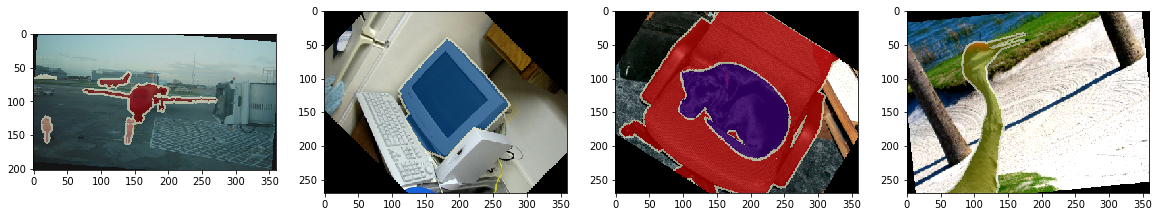

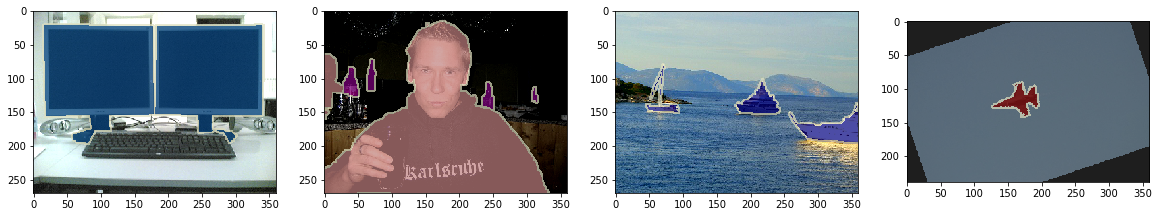

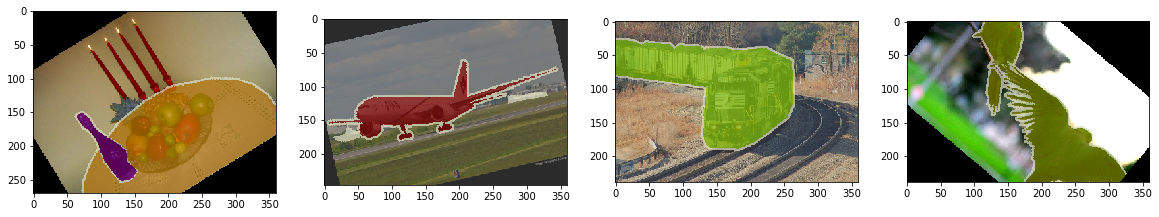

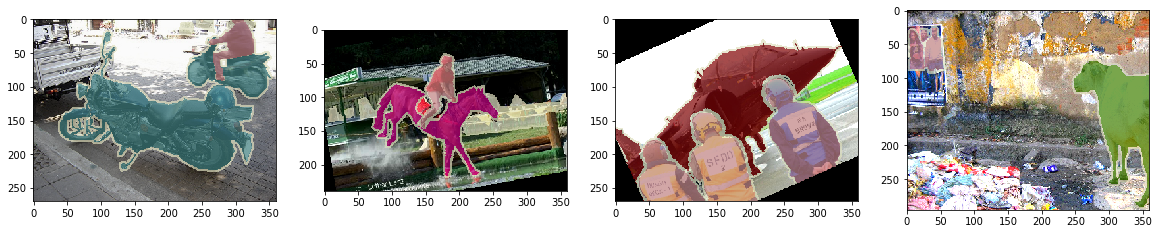

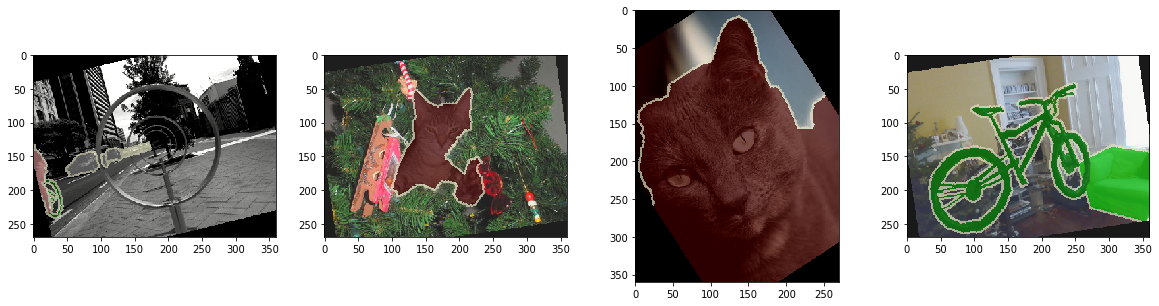

In [14]:
for _ in range(5):
    pipe_out = pipe.run()
    batch_x, batch_y = pipe_out

    plt.figure(figsize=(20, 5))
    for i in range(min(len(batch_x), len(batch_y))):
        img1 = batch_x.asCPU().at(i)
        mask1 = batch_y.asCPU().at(i)
        plt.subplot(1, 4, i + 1)
        plt.imshow(render_datapoint(img1, mask1, output_size=(360, 360)))

### With WarpAffine -> does not work

In [69]:
import math


def get_inverse_affine_matrix(center, angle, translate, scale, shear):
    # Helper method to compute inverse matrix for affine transformation

    # We need compute inverse of affine transformation matrix: M = T * C * RSS * C^-1
    # where T is translation matrix: [1, 0, tx | 0, 1, ty | 0, 0, 1]
    #       C is translation matrix to keep center: [1, 0, cx | 0, 1, cy | 0, 0, 1]
    #       RSS is rotation with scale and shear matrix
    #       RSS(a, scale, shear) = [ cos(a)*scale    -sin(a + shear)*scale     0]
    #                              [ sin(a)*scale    cos(a + shear)*scale     0]
    #                              [     0                  0          1]
    # Thus, the inverse is M^-1 = C * RSS^-1 * C^-1 * T^-1

    angle = math.radians(angle)
    shear = math.radians(shear)
    scale = 1.0 / scale

    # Inverted rotation matrix with scale and shear
    d = math.cos(angle + shear) * math.cos(angle) + math.sin(angle + shear) * math.sin(angle)
    matrix = [
        math.cos(angle + shear), math.sin(angle + shear), 0,
        -math.sin(angle), math.cos(angle), 0
    ]
    matrix = [scale / d * m for m in matrix]

    # Apply inverse of translation and of center translation: RSS^-1 * C^-1 * T^-1
    matrix[2] += matrix[0] * (-center[0] - translate[0]) + matrix[1] * (-center[1] - translate[1])
    matrix[5] += matrix[3] * (-center[0] - translate[0]) + matrix[4] * (-center[1] - translate[1])

    # Apply center translation: C * RSS^-1 * C^-1 * T^-1
    matrix[2] += center[0]
    matrix[5] += center[1]
    return matrix


m = get_inverse_affine_matrix(center=(0, 0), angle=45, translate=(0, 0), scale=2.0, shear=0.0)
m

[0.3535533905932738,
 0.35355339059327373,
 0.0,
 -0.35355339059327373,
 0.3535533905932738,
 0.0]

In [88]:
class VOCSegmentationAugmentedPipeline(VOCSegmentationSourcePipeline):
    
    def __init__(self, batch_size, num_threads, device_id, seed=12, **dataset_kwargs):
        super(VOCSegmentationAugmentedPipeline, self).__init__(batch_size, 
                                                               num_threads,
                                                               device_id, 
                                                               seed=seed, **dataset_kwargs)
        
        # Random affine warp
        self.affine_proba = ops.CoinFlip(probability=0.5)
        self.affine_rand_angle = ops.Uniform(range=[-90.0, 90.0])
        self.affine_rand_scale = ops.Uniform(range=[-0.75, 1.25])
        self.affine_rand_shear = ops.Uniform(range=[-0.15, 0.15])
        self.affine_rand_translate = ops.Uniform(range=[-0.2, 0.2])
        self.affine = ops.WarpAffine(device="gpu", use_image_center=False)
                
    def define_graph(self):
        self.images = self.input_images(name="ImageReader")
        self.masks = self.input_masks(name="MaskReader")
        images = self.image_decode(self.images)
        masks = self.mask_decode(self.masks)
        
        img_width = 512 // 2
        img_height = 512 // 2
        center = (img_width * 0.5, img_height * 0.5)
        angle = self.affine_rand_angle()
        scale = self.affine_rand_scale()
        print(angle.source, scale.source)
        translate = (img_width * self.affine_rand_translate(), img_height * self.affine_rand_translate())
        mask = self.affine_proba()
        
        matrix = get_inverse_affine_matrix(center=center, angle=angle, scale=scale, translate=translate)
        images = self.affine(images, matrix=matrix, fill_value=0, interp_type=types.INTERP_CUBIC, mask=mask)
        masks = self.affine(masks, matrix=matrix, fill_value=0, interp_type=types.INTERP_NN, mask=mask)        

        return (images, masks)        

In [83]:
pipe = VOCSegmentationSourcePipeline(root="/home/storage_ext4_1tb/", batch_size=4, num_threads=2, device_id=0)
pipe.build()
pipe_out = pipe.run()

In [86]:
from nvidia.dali.tensor import TensorReference

In [87]:
TensorReference??

Init signature: TensorReference(name, device='cpu', source=None)
Docstring:      <no docstring>
Source:        
class TensorReference(object):
    def __init__(self, name, device="cpu", source=None):
        self.name = name
        self.device = device
        self.source = source

    # Note: Regardless of whether we want the cpu or gpu version
    # of a tensor, we keep the source argument the same so that
    # the pipeline can backtrack through the user-defined graph
    def cpu(self):
        return TensorReference(self.name, "cpu", self.source)

    def gpu(self):
        return TensorReference(self.name, "gpu", self.source)
File:           /usr/local/lib/python3.5/dist-packages/nvidia/dali/tensor.py
Type:           type
Subclasses:     


In [89]:
pipe = VOCSegmentationAugmentedPipeline(root="/home/storage_ext4_1tb/", batch_size=4, num_threads=2, device_id=0)
pipe.build()
pipe_out = pipe.run()

<nvidia.dali.ops._OperatorInstance object at 0x7fa38512fe48> <nvidia.dali.ops._OperatorInstance object at 0x7fa38512f898>


TypeError: unsupported operand type(s) for *: 'int' and 'TensorReference'

In [34]:
x, y = pipe_out

In [39]:
img1 = x.asCPU().at(1)
mask1 = y.at(1)

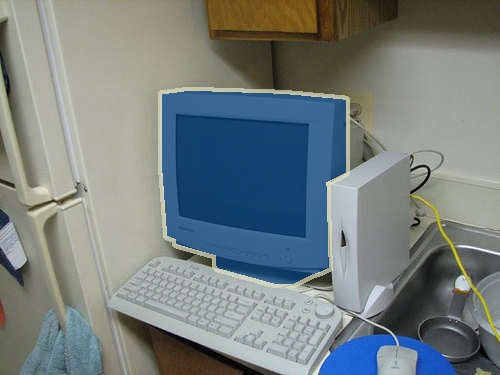

In [40]:
render_datapoint(img1, mask1)

In [ ]:
voc_input = ops.FileReader(file_root=data_dir, shard_id=args.local_rank, num_shards=args.world_size, random_shuffle=True)

In [8]:
ops.HostDecoderRandomCrop??

Object `ops.HostDecoderRandomCrop` not found.


In [ ]:
class HybridTrainPipe(Pipeline):
    def __init__(self, batch_size, num_threads, device_id, data_dir, crop, dali_cpu=False):
        super(HybridTrainPipe, self).__init__(batch_size, num_threads, device_id, seed=12 + device_id)
        self.input = ops.FileReader(file_root=data_dir, shard_id=args.local_rank, num_shards=args.world_size, random_shuffle=True)
        #let user decide which pipeline works him bets for RN version he runs
        if dali_cpu:
            dali_device = "cpu"
            self.decode = ops.HostDecoderRandomCrop(device=dali_device, output_type=types.RGB)
            self.res = ops.Resize(resize_x=crop, resize_y=crop)
        else:
            dali_device = "gpu"
            # This padding sets the size of the internal nvJPEG buffers to be able to handle all images from full-sized ImageNet
            # without additional reallocations
            self.decode = ops.nvJPEGDecoder(device="mixed", output_type=types.RGB, device_memory_padding=211025920, host_memory_padding=140544512)
            self.res = ops.RandomResizedCrop(device=dali_device, size =(crop, crop))

        self.cmnp = ops.CropMirrorNormalize(device="gpu",
                                            output_dtype=types.FLOAT,
                                            output_layout=types.NCHW,
                                            crop=(crop, crop),
                                            image_type=types.RGB,
                                            mean=[0.485 * 255,0.456 * 255,0.406 * 255],
                                            std=[0.229 * 255,0.224 * 255,0.225 * 255])
        self.coin = ops.CoinFlip(probability=0.5)
        print('DALI "{0}" variant'.format(dali_device))

    def define_graph(self):
        rng = self.coin()
        self.jpegs, self.labels = self.input(name="Reader")
        images = self.decode(self.jpegs)
        images = self.res(images)
        output = self.cmnp(images.gpu(), mirror=rng)
        return [output, self.labels]


class HybridValPipe(Pipeline):
    def __init__(self, batch_size, num_threads, device_id, data_dir, crop, size):
        super(HybridValPipe, self).__init__(batch_size, num_threads, device_id, seed=12 + device_id)
        self.input = ops.FileReader(file_root=data_dir, shard_id=args.local_rank, num_shards=args.world_size, random_shuffle=False)
        self.decode = ops.nvJPEGDecoder(device="mixed", output_type=types.RGB)
        self.res = ops.Resize(device="gpu", resize_shorter=size)
        self.cmnp = ops.CropMirrorNormalize(device="gpu",
                                            output_dtype=types.FLOAT,
                                            output_layout=types.NCHW,
                                            crop=(crop, crop),
                                            image_type=types.RGB,
                                            mean=[0.485 * 255,0.456 * 255,0.406 * 255],
                                            std=[0.229 * 255,0.224 * 255,0.225 * 255])

    def define_graph(self):
        self.jpegs, self.labels = self.input(name="Reader")
        images = self.decode(self.jpegs)
        images = self.res(images)
        output = self.cmnp(images)
return [output, self.labels]

In [1]:
from image_dataset_viz import render_datapoint

In [3]:
from dataflow.dataloaders import get_train_val_loaders

In [ ]:
root_path = "/home/storage_ext4_1tb/"

train_loader, val_loader, train_eval_loader = get_train_val_loaders(root_path, train)

Use 

In [21]:
import numbers

a = np.array([0, 1, 2, 3])

isinstance(a[0], int), isinstance(a[0], numbers.Integral)

(False, True)